# LoRA From Scratch: Results & Visualization

This notebook visualizes the performance of our custom LoRA implementation.
We will cover:
1.  **Inference Latency**: Comparing Baseline vs. Unmerged LoRA vs. Merged LoRA.
2.  **Training Metrics**: Fetching loss curves from Weights & Biases.
3.  **Real-World Integration**: Verifying LoRA injection into OPT-125m.

In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForCausalLM

# Ensure local modules are movable
sys.path.append(os.path.abspath('src'))
sys.path.append(os.path.abspath('benchmarks'))

from lora_from_scratch.model import inject_lora, mark_only_lora_as_trainable
from benchmark_inference import benchmark_inference

## 1. Inference Benchmarks

We verify that the 'Merged' LoRA model has zero overhead compared to the baseline.

Benchmarking Baseline...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Baseline] Average Latency: 2.9460 ms
Benchmarking Unmerged LoRA...
[Unmerged] Average Latency: 3.4244 ms
Benchmarking Merged LoRA...
[Merged] Average Latency: 2.6497 ms


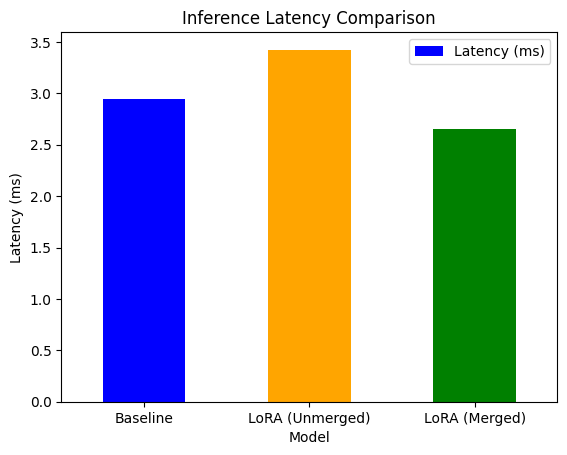

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
text = "This is a sample sentence to benchmark the inference latency of the model."
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

results = {}

# 1. Baseline
print("Benchmarking Baseline...")
baseline_model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
results['Baseline'] = benchmark_inference(baseline_model, input_ids, attention_mask, n_steps=50, label="Baseline")

# 2. LoRA (Unmerged)
print("Benchmarking Unmerged LoRA...")
lora_model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
inject_lora(lora_model, target_modules=["q_lin", "v_lin"], rank=8, alpha=16, verbose=False)
lora_model.to(device) # Ensure new weights are on device
results['LoRA (Unmerged)'] = benchmark_inference(lora_model, input_ids, attention_mask, n_steps=50, label="Unmerged")

# 3. LoRA (Merged)
print("Benchmarking Merged LoRA...")
for m in lora_model.modules():
    if hasattr(m, 'merge'):
        m.merge()
results['LoRA (Merged)'] = benchmark_inference(lora_model, input_ids, attention_mask, n_steps=50, label="Merged")

# Plot
df = pd.DataFrame(list(results.items()), columns=['Model', 'Latency (ms)'])
ax = df.plot(kind='bar', x='Model', y='Latency (ms)', rot=0, color=['blue', 'orange', 'green'])
plt.title("Inference Latency Comparison")
plt.ylabel("Latency (ms)")
plt.show()

## 2. Training Results (Weights & Biases)

We fetch the runs from W&B to compare the loss curves.

wandb: Currently logged in as: tad537113 (tad537113-university-of-texas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


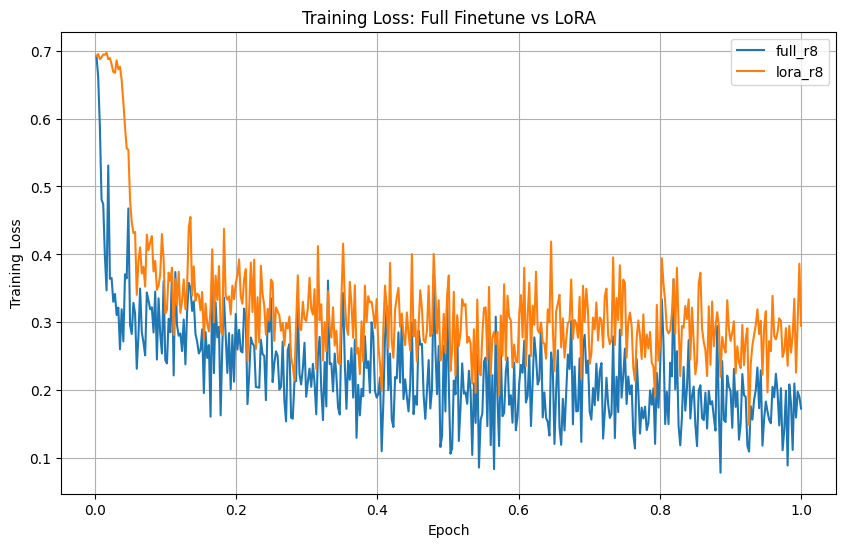

In [3]:
# Replace with your entity/project if different
try:
    api = wandb.Api()
    runs = api.runs("lora-from-scratch-benchmarks")

    history_list = []
    for run in runs:
        if run.state == "finished":
            hist = run.history(keys=["train/loss", "train/epoch"])
            hist['name'] = run.name
            history_list.append(hist)

    if history_list:
        plt.figure(figsize=(10, 6))
        for hist in history_list:
            plt.plot(hist['train/epoch'], hist['train/loss'], label=hist['name'].iloc[0])
        
        plt.xlabel("Epoch")
        plt.ylabel("Training Loss")
        plt.title("Training Loss: Full Finetune vs LoRA")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No finished runs found in W&B project 'lora-from-scratch-benchmarks'.")
except Exception as e:
    print(f"Could not fetch W&B data: {e}")

## 3. Real-World Integration (OPT-125m)

We load `facebook/opt-125m`, inject LoRA adapters into `q_proj` and `v_proj`, and verify the parameter counts.
This confirms that our custom `LoRALinear` correctly replaces standard `nn.Linear` layers in a complex Transformer model.

In [6]:
print("Loading facebook/opt-125m...")
model_id = "facebook/opt-125m"
opt_model = AutoModelForCausalLM.from_pretrained(model_id)
device = "cuda" if torch.cuda.is_available() else "cpu"
opt_model.to(device)

# 1. Inject LoRA
# OPT-125m uses 'q_proj' and 'v_proj' in its attention layers
print("Injecting LoRA...")
inject_lora(opt_model, target_modules=["q_proj", "v_proj"], rank=4, alpha=16, verbose=True)

# 2. Verify Trainable Parameters
mark_only_lora_as_trainable(opt_model)

total_params = sum(p.numel() for p in opt_model.parameters())
trainable_params = sum(p.numel() for p in opt_model.parameters() if p.requires_grad)

print(f"\nVERIFICATION RESULTS:")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters (LoRA only): {trainable_params:,}")
print(f"Trainable %: {100 * trainable_params / total_params:.4f}%")

if trainable_params > 0 and trainable_params < total_params:
    print("\n[SUCCESS] LoRA injected and model frozen correctly!")
else:
    print("\n[FAILURE] Parameter counts look wrong.")

Loading facebook/opt-125m...
Injecting LoRA...
Injecting LoRA (rank=4, alpha=16) into modules matching: ['q_proj', 'v_proj']
  Replacing: model.decoder.layers.0.self_attn.v_proj (768 -> 768)
  Replacing: model.decoder.layers.0.self_attn.q_proj (768 -> 768)
  Replacing: model.decoder.layers.1.self_attn.v_proj (768 -> 768)
  Replacing: model.decoder.layers.1.self_attn.q_proj (768 -> 768)
  Replacing: model.decoder.layers.2.self_attn.v_proj (768 -> 768)
  Replacing: model.decoder.layers.2.self_attn.q_proj (768 -> 768)
  Replacing: model.decoder.layers.3.self_attn.v_proj (768 -> 768)
  Replacing: model.decoder.layers.3.self_attn.q_proj (768 -> 768)
  Replacing: model.decoder.layers.4.self_attn.v_proj (768 -> 768)
  Replacing: model.decoder.layers.4.self_attn.q_proj (768 -> 768)
  Replacing: model.decoder.layers.5.self_attn.v_proj (768 -> 768)
  Replacing: model.decoder.layers.5.self_attn.q_proj (768 -> 768)
  Replacing: model.decoder.layers.6.self_attn.v_proj (768 -> 768)
  Replacing: mode